In [1]:
import arviz as az
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pymc as pm
import pytensor.tensor as pt
import requests
import statsmodels.api as sm
import warnings
import xarray as xr

In [2]:
countries_iso = ['BEL', 'DNK', 'FRA', 'GBR', 'ITA', 'NLD', 'NOR', 'PRT']
countries_names = ['Belgium', 'Denmark', 'France', 'United Kingdom', 'Italy',
                   'Netherlands', 'Norway', 'Portugal']

In [3]:
data_path = Path(Path.cwd().parent / "data processed" / "nato_dataset.csv")
print("NATO dataset")
print("Full file path: ",data_path)
print("File exists: ",data_path.exists())

NATO dataset
Full file path:  /Users/awalters/escp_phd/govt_spending/data processed/nato_dataset.csv
File exists:  True


In [4]:
df = pd.read_csv(data_path)

In [5]:
def build_panel_var_design_fast(df, y_vars, p=1):
    df = df.copy()
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df = df.dropna(subset=["iso", "year"])
    df = df.sort_values(["iso", "year"])

    pieces = []
    for iso, g in df.groupby("iso", sort=False):
        g = g.sort_values("year")
        Yg = g[y_vars]

        # create all lags at once (no fragmentation)
        lagged = pd.concat(
            {f"L{l}": Yg.shift(l) for l in range(1, p + 1)},
            axis=1
        )
        # flatten MultiIndex columns: (L#, var) -> var_L#
        lagged.columns = [f"{var}_{lag}" for lag, var in lagged.columns]

        out = pd.concat([g[["iso", "year"] + y_vars], lagged], axis=1)
        pieces.append(out)

    d = pd.concat(pieces, axis=0)

    lag_cols = [f"{v}_L{l}" for l in range(1, p + 1) for v in y_vars]
    d = d.dropna(subset=y_vars + lag_cols).copy()

    countries = np.array(sorted(d["iso"].unique()))
    iso_to_idx = {iso: i for i, iso in enumerate(countries)}
    c_idx = d["iso"].map(iso_to_idx).to_numpy()

    Y = d[y_vars].to_numpy()
    X = d[lag_cols].to_numpy()  # only lags => BVAR (no exog, no const)

    return Y, X, c_idx, countries, d

In [6]:
p = 15

y_vars = [
    "mil_delta",
    "log_gov_pc",
    "log_rgdp_pc",
    "tbill",
    "log_tfp",
    "def_gdp",
    "debt_gdp",
]

Y, X, c_idx, countries, d_used = build_panel_var_design_fast(df, y_vars=y_vars, p=15)


N, K = Y.shape
M = X.shape[1]
print("N,K,M =", N, K, M, "  K*p =", K*p)

N,K,M = 440 8 120   K*p = 120


In [7]:
Y_mean = Y.mean(axis=0)
Y_std  = Y.std(axis=0, ddof=0)
Yz = (Y - Y_mean) / Y_std

X_mean = X.mean(axis=0)
X_std  = X.std(axis=0, ddof=0)
X_std[X_std == 0] = 1.0
Xz = (X - X_mean) / X_std

In [8]:
lam1, lam2, lam3 = 0.2, 0.5, 1.0

prior_mu = np.zeros((M, K))
prior_sd = np.zeros((M, K))

for l in range(1, p + 1):
    base = lam1 / (l ** lam3)
    for j in range(K):              # predictor var
        row = (l - 1) * K + j
        for k in range(K):          # equation
            if l == 1 and j == k:
                prior_mu[row, k] = 1.0
            prior_sd[row, k] = base if (j == k) else (base * lam2)

In [9]:
C = len(countries)

with pm.Model() as panel_bvar:
    X_data = pm.Data("X", Xz)
    Y_data = pm.Data("Y", Yz)
    c_data = pm.Data("c_idx", c_idx)

    alpha = pm.Normal("alpha", 0.0, 1.0, shape=(C, K))
    B     = pm.Normal("B", mu=prior_mu, sigma=prior_sd, shape=(M, K))

    L, corr, sigmas = pm.LKJCholeskyCov(
        "L", n=K, eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )

    mu = alpha[c_data] + pm.math.dot(X_data, B)
    y  = pm.MvNormal("y", mu=mu, chol=L, observed=Y_data)

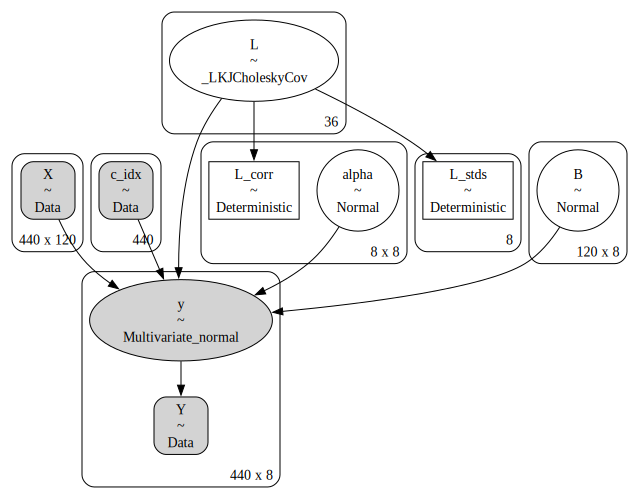

In [10]:
pm.model_to_graphviz(panel_bvar)

In [11]:
with panel_bvar:
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=10,
        cores=10,
        target_accept=0.95,
        mp_ctx="spawn",          # <-- macOS often happier with spawn
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [alpha, B, L]


Output()

/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pytensor/compile/function/types.py:1038: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)
/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/pytensor/compile/function/types.py:1038: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 1228 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 4 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 6 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 rea

In [19]:
vars_endog = [
    "mil_delta",
    "log_gov_pc",
    "log_rgdp_pc",
    "tbill",
    "log_tfp",
    "def_gdp",
    "debt_gdp",
]

p = 15
H = 15
shock_var = "mil_delta"

periods_per_year = 1   # annual data; set to 4 if quarterly

In [20]:
def stack_draws(da: xr.DataArray) -> xr.DataArray:
    # (chain, draw, ...) -> (sample, ...)
    return da.stack(sample=("chain", "draw")).transpose("sample", ...)

def unpack_lower_tri(packed, K):
    # packed length K*(K+1)//2 -> (K,K) lower-triangular
    L = np.zeros((K, K), dtype=float)
    idx = 0
    for i in range(K):
        for j in range(i + 1):
            L[i, j] = packed[idx]
            idx += 1
    return L

def build_A_from_B(B_draws, K, p):
    """
    B_draws: (S, M, K) where M should be K*p (lags only)
    Returns A_draws: (S, p, K, K) with A_l mapping y_{t-l} -> y_t
    """
    S, M, K2 = B_draws.shape
    if K2 != K:
        raise ValueError(f"K mismatch: B has {K2} equations but vars_endog has {K}")
    if M < K * p:
        raise ValueError(f"M too small: M={M} but K*p={K*p}")
    if M != K * p:
        raise ValueError(f"This looks like VARX/const: M={M} but K*p={K*p}. For pure BVAR, they must match.")

    A = np.zeros((S, p, K, K))
    for l in range(1, p + 1):
        block = B_draws[:, (l - 1) * K : l * K, :]   # (S, K predictors, K equations)
        A[:, l - 1, :, :] = np.swapaxes(block, 1, 2) # (S, K eqns, K preds)
    return A

def irfs_endog(A_draws, shock_idx, H, chol_draws=None, shock_size=1.0):
    """
    VAR: y_t = sum_l A_l y_{t-l} + u_t
    If chol_draws provided: orthogonalized shocks u_t = L @ e_k
    Returns: (S, H+1, K)
    """
    S, p, K, _ = A_draws.shape
    out = np.zeros((S, H + 1, K))

    e = np.zeros(K)
    e[shock_idx] = shock_size

    for s in range(S):
        out[s, 0, :] = e if chol_draws is None else (chol_draws[s] @ e)
        for h in range(1, H + 1):
            acc = np.zeros(K)
            for l in range(1, p + 1):
                if h - l >= 0:
                    acc += A_draws[s, l - 1] @ out[s, h - l]
            out[s, h, :] = acc
    return out

In [21]:
K = len(vars_endog)
shock_idx = vars_endog.index(shock_var)

# Posterior draws
B_post = stack_draws(trace.posterior["B"]).values   # (S, M, K)
A_draws = build_A_from_B(B_post, K=K, p=p)

# Unpack L if needed
L_raw = stack_draws(trace.posterior["L"]).values
if L_raw.ndim == 2 and L_raw.shape[1] == K * (K + 1) // 2:
    L_post = np.stack([unpack_lower_tri(L_raw[s], K) for s in range(L_raw.shape[0])], axis=0)
else:
    L_post = L_raw  # already (S,K,K)

# shock size
shock_size_std = 1.0 / Y_std[shock_idx]   # +1.0 in original units of mil_delta

# 1) Start with a 1-unit *structural* shock
irfs_std = irfs_endog(A_draws, shock_idx=shock_idx, H=H, chol_draws=L_post, shock_size=1.0)

# 2) Convert to original units
irfs_unstd = irfs_std * Y_std[None, None, :]

# 3) Normalize so the SHOCK VARIABLE moves by +1 unit on impact (h=0)
target = 1.0  # e.g., +1pp-of-GDP in mil_delta units
impact0 = irfs_unstd[:, 0, shock_idx]              # (S,)
scale_draw = target / impact0                      # (S,)
irfs_unstd = irfs_unstd * scale_draw[:, None, None]

In [22]:
log_vars = {"log_gov_pc", "log_rgdp_pc", "log_tfp"}
irfs_plot = irfs_unstd.copy()
for j, name in enumerate(vars_endog):
    if name in log_vars:
        irfs_plot[:, :, j] = 100.0 * irfs_plot[:, :, j]

In [23]:
def to_percent_from_log(x):
    return 100.0 * (np.exp(x) - 1.0)
irfs_plot = irfs_units.copy()

for v in ["log_gov_pc", "log_rgdp_pc", "log_tfp"]:
    j = vars_endog.index(v)
    irfs_plot[:, :, j] = 100.0 * (np.exp(irfs_plot[:, :, j]) - 1.0)

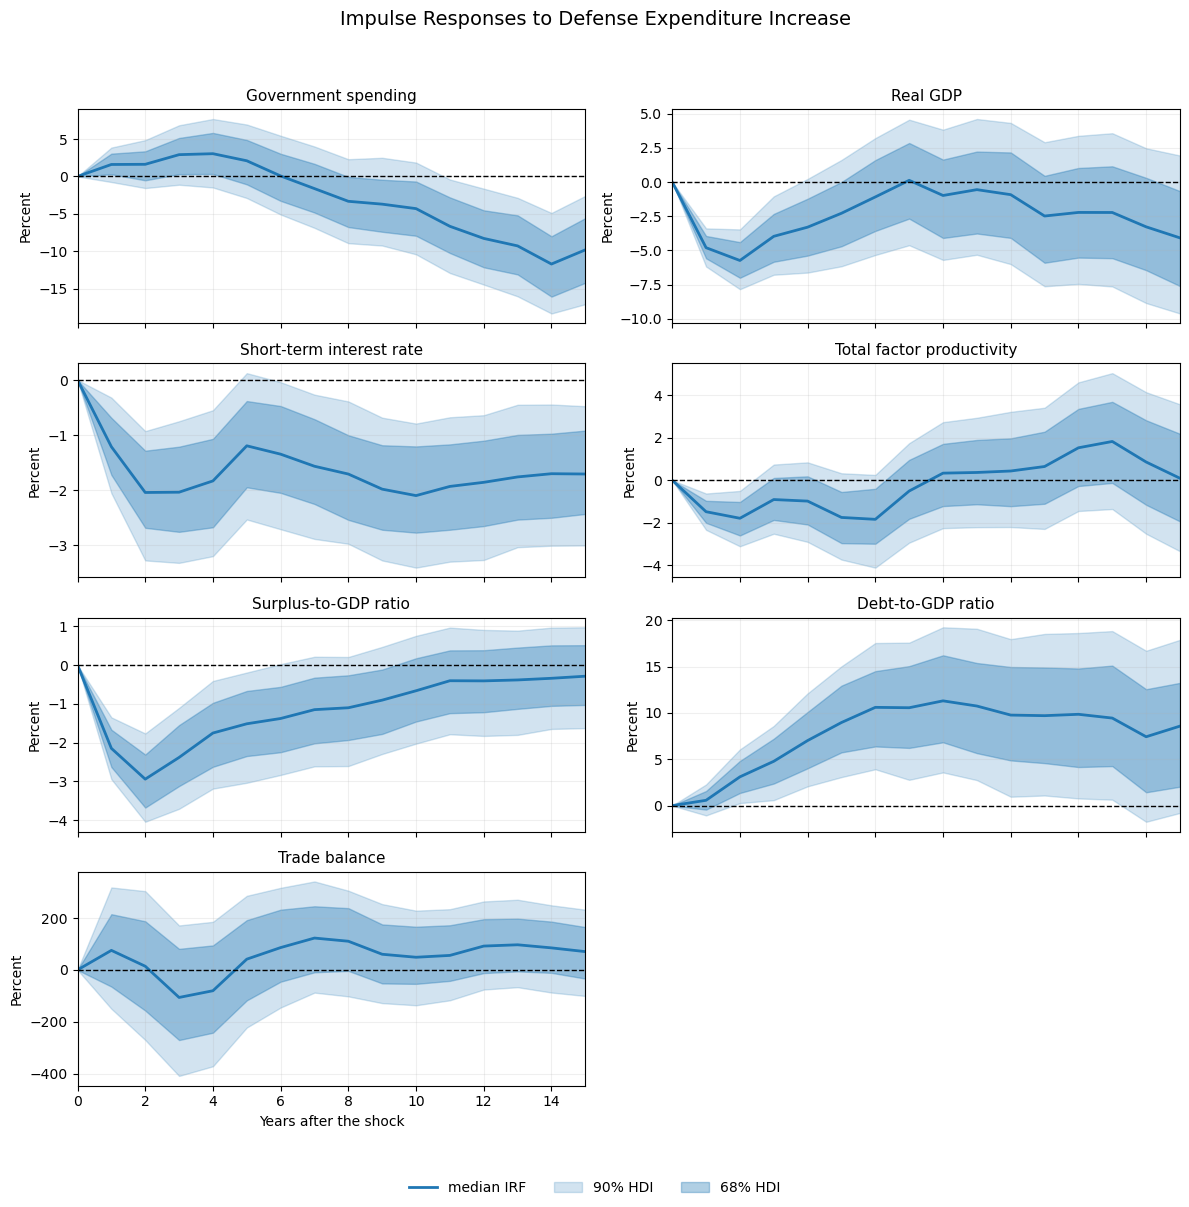

In [24]:
pretty = {
    "log_gov_pc": "Government spending",
    "log_rgdp_pc": "Real GDP",
    "tbill": "Short-term interest rate",
    "log_tfp": "Total factor productivity",
    "def_gdp": "Surplus-to-GDP ratio",
    "debt_gdp": "Debt-to-GDP ratio",
    "mil_delta": "Military expenditure shock",
}

horiz_years = np.arange(H + 1) / periods_per_year

nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)
axes = axes.ravel()

xmax = 15
xticks = np.arange(0, xmax + 1, 2)

names = [v for v in vars_endog if v != shock_var]  # skip shock var

for ax, name in zip(axes, names):
    j = vars_endog.index(name)

    y = irfs_plot[:, :, j]  # (draw, horizon)
    med = np.median(y, axis=0)

    arr = xr.DataArray(y, dims=("draw", "horizon")).expand_dims(chain=[0])
    hdi68 = az.hdi(arr, hdi_prob=0.68).to_array().squeeze()
    hdi90 = az.hdi(arr, hdi_prob=0.90).to_array().squeeze()

    lo68 = hdi68.sel(hdi="lower").values
    hi68 = hdi68.sel(hdi="higher").values
    lo90 = hdi90.sel(hdi="lower").values
    hi90 = hdi90.sel(hdi="higher").values

    ax.plot(horiz_years, med, linewidth=2, color="C0", label="median IRF")
    ax.fill_between(horiz_years, lo90, hi90, alpha=0.20, color="C0", label="90% HDI")
    ax.fill_between(horiz_years, lo68, hi68, alpha=0.35, color="C0", label="68% HDI")

    ax.axhline(0, lw=1, ls="--", color="black")
    ax.set_xlim(0, xmax)
    ax.set_xticks(xticks)

    ax.set_title(pretty.get(name, name), fontsize=11)
    ax.set_ylabel("Percent")
    ax.grid(alpha=0.2)

for k in range(len(names), len(axes)):
    axes[k].axis("off")

for ax in axes[-ncols:]:
    ax.set_xlabel("Years after the shock")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, frameon=False)

fig.suptitle("Impulse Responses to Defense Expenditure Increase", y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0.05, 1, 0.97])

outpath = Path.cwd() / "figures" / "panel_bvar_irfs_mil_delta.png"
outpath.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(outpath, dpi=200)
plt.show()

In [25]:
shock_idx = vars_endog.index("mil_delta")
print("Median impact on mil_delta (h=0):", np.median(irfs_units[:, 0, shock_idx]))

Median impact on mil_delta (h=0): 1.0
